# Transformers

Transformers are a sophisiticated modern neural network best adapted to sequential data. They are in the process of replacing the recurrent neural network as the de-facto model for sequence analysis. As a brief review: recurrent neural networks incorporate information about sequential dependencies through recurrent connections which allow a hidden state to incorporate variables that have been previously exposed to the network. There are some principle shortcomings with this approach: short memory, exploding/vanishing gradients, and $O(n)$ complexity. Tokens that are historically adjacent to each other have more weight and thus the information in the sequence decays over long ranges; the network has a relatively short memory. The hidden state is called recursively over the course of training and thus the gradients have a tendency to either explode or vanish and various regularisation tricks are needed to stablise the training routine. Finally, the current hidden state depends on the previous hidden state and the data must therefore be parsed sequentially - there is no parallelisation routine. This results in very computationally intensive training.

The Transformer was introduced in 2016 in the seminal paper [Attention is all you need](https://arxiv.org/abs/1706.03762) and since then have been the basis of most large language models. They neatly solve all three problems with reccurent neural networks with the idea of attention. It should be noted that attention is not a pioneering feature of this paper. However, the attention mechanisms neatly allows the author to encode long range and importantly asymetric dependencies between sequence tokens. These attention representations are bidirectional and all-to-all allowing for massive parrallelisation within an attention layer. They are also relatively stable in their gradients because attention representations are not recursively computed.

The outcomes of this notebook are:

* Understanding attention and multi-head attention.
* Creating a custom Flux layer to represent attention heads.
* Understanding sequence generation.
* A comprenhensive look at the transformer architecture.
* Implementing a custom Transformer network.
* Training a Transformer on biological sequence data.

## Self Attention

Attention is the key concept in the Transformer model. It heuristically refers to how much each element in the sequence relates to one and other. The simplest form of this is the Euclidean projection of one vector onto another and the attention matrix is accordingly defined by dot-product; recall that the dot product has the geometric intepretation of how much one element projects onto another. Suppose that the sequence elements are $v_i$

$$ W_{ij} = v_j v_i^T $$

Now that we have created the attention relationships we want to output some intepretable configuration of vectors that incorporate these relationships. The most straightforward approach is a weighted linear combination of all vectors in the sequence: the attention weights are used to incorporate each vectors influence on each other vector.

$$ a_i = \sum_j W_{ij} v_j $$

Finally, we want to scale these outputs into the "interpretable" regime therefore we apply a normalisation factor (scaling by the sqrt of the dimensionality) and the `softmax` function to convert these output into a probability distribution. These are just implementation details. The next thing we can note, and the algebra suggests it automatically, is that this can be parallelised. We can concatenate all the input vectors into a matrix $A$ and pre-multiply it by the weight matrix $W$ completing the attention transformation in a single step.

$$ V = \text{softmax}\left(\frac{W}{\sqrt{d}}\right) V$$

## Keys, Queries, and Values
Up until this point we have not provided any mechanism to *learn*. It would be perculiar if the primary component of a learning algorithm had no learnable parameters. Before we rectify this we need to clarify some terminology. If we apply the same vector concatenation trick to constructing the attention matrix we find that the attention matrix $W$ is the product of two matrices $A$ and $A^T$ which for now we will label $K$ and $Q$. Let's imagine that each of the input vectors where one-hot encoded: they had a 1 in a singular index and a 0 elsewhere. The resulting attention weights would be one if and only if the input indexes were identical: $i = j$. This means that the operation is acting like a dictionary or look-up table would act: if the first vector matches the second vector output a Boolean true. In computer science these are generally labelled *keys* and *queries*. These terms motivate our matrices $K$ and $Q$. The final component of the look up table is to output the value associated with a queried key. These are nothing more than the input vectors again and are encoded in our $V$ matrix.

So far, the input vectors have played the key role in all the operations and we cant expect to learn much about their relational structure. Let's suppose that there is a more efficient lookup table that could encoded the data. This would amount to an abitrary set of keys and queries, but the values would remain the same. We can imagine the keys and queries as embedding matrices and this would allow us to embedd our inputs in a lower (or higher) dimensional space. Therefore, if the input tokens $v_i$ are vectors of length $N$ and we want to embed them into a space of dimension $P$ then our key and query matrices should have dimensions $N \times P$ and $P \times N$ respectively. These matrices will now be intialised in a way that does not need to depend on $v_i$, usually just a random number in each slot. The goal will be to learn the best form of these matrices. This can be thought of in much the same way as a convolutional filter where the goal was to learn the kernel weights. We finally arrive at the complete attention equation:

$$ A(K, Q, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d}}\right)V $$.

## Positional Encoding
The key and query matrices allow the data to interact with each other bidirectionally and asymetrically (one element can pay more attention to other elements than those elements pay to it: think of a fan that dotes on a celebrity). However, this comes at the cost of losing sequence information as the indexes are not encoded in the learning protocol. The ordering is usually extremely important for sequentially organised data and we do not want to through out this ordering. To incorporate it we augment our input vectors with a number that indicates the relative ordering. This is commonly chosen to be a sinusoid (but this choice is abitrary). The encoding is typically:

$$ p_d(x, i) = \sin \left( \frac{{x^{\frac{2i}{d}}}}{10000}  \right) $$

This encoding is acting as another embedding in the same fashion as the keys and queries matrices. This, in principle, could also be learned. However, we choose a fixed function because in practice the learned results do not vastly outperform a fixed embedding and they come at a larger cost.

## Attention Heads

The attention operation in conjunction with the positional encoding form an *attention head*. This is nothing more than a learned representation of what and where each element in the sequence should be pay attention to. It is certainly possible that different sub-sequences mean different things to one and other in different contexts. This can be represented with multiple attention heads operating on the same inputs. As an analogy, think of the different features that can be extracted by having multiple convolutional kernels in each layer. Multihead attention is exteremely easy to implement. Simply concatentate the key/query matrices together linearly. In a similar analogy to convolutional networks attention heads may be composed in layers. The outputs of an attention head are a vector of weighted attention cues. These can be passed to a new set of attention matrices. In doing so we can learn deep and convoluted relationships. We are now ready to create our custom attention head and multiattention head types.

In [ ]:
struct Attention
    Q::Matrix
    K::Matrix
    d::Int
    function Attention(sequencedimension, embeddingdimension)
        Q = rand(embeddingdimension, sequencedimension)
        K = rand(sequencedimension, embeddingdimension)
        new(Q, K, sequencedimension)
    end
end

struct MultiHeadAttention
    Q::Matrix
    K::Matrix
    d::Int
    function MultiHeadAttention(attentionheads...)
        Q = hcat(attentionheads.Q...)
        K = vcat(attentionheads.K...)
        d = attentionheads[1].d
        new(Q, K, d)
    end
end

(a::Union{Attention, MultiHeadAttention})(V) = Flux.softmax(a.K * a.Q ./ sqrt(d)) .* V

# The Transformer Architecture
The Transformer uses attention as its principle working mechanism but it itself is a neural network architecture. It is composed of an encoder and a decoder. Each of these has several layers of multi-head attention and in-between the layers are Dense perceptron layers. This allows the vectors to be appropriately transformed/classified at each step. The encoder component is relatively straightforward - feed it the input vectors and record the final output. The decoder layer is slightly more sophisticated.

A single pass of the decoder proceeds as follows: take a new input (not one of the encoder inputs) and pass it through an attention layer. This is the self-attention layer of the decoder. For every subsequent attention layer the encoder outputs will be combined with the decoder pass. These will go through multi-head attention layers, be normalised, and then passed through a Dense perceptron layer as in the encoder. 

[IMG Transfomer]


## Output Decoding

To generate the output sequence the Transformer proceeds in much the same way as a traditional sequence decoder. It takes a `start` symbol and generates data sequentially until a `stop` symbol is generated. The outputs are encoded in an arbitrarily long vector that is expected to be longer than the length of the output sentence e.g. 512. The output layer is decoded using outputs generated up until the point of the sequence as inputs with a mask of `-Inf` for future ouputs. 

The masked output is used to generate its own query values and is combined with a positional encoding in the same fashion as the input layer. Then it is generally passed through its own self attention layer with masked multi-head attention before interacting with the encoded keys and values. The queries are combined with the encoder results to generate the next sequential output. This is autoregression.

## Implementing the Transformer

The Transformer is an inherently simple architecture and it is fairly straightforward to take a custom type as defined before and proceed through Zygote backpropogation and Flux API calls to complete training. However, as always, implementing this will require uninformative boiler-plate code. We have covered how one might implement custom architectures through custom layer types in previous notebooks and these can be used for reference. In this implementation we will use an existing package in the Flux ecosystem: `Transformers.jl`.

## Acid-Amino Sequence Prediction: Learning the Language of Codons



In [4]:
using CSV, DataFrames, Transformers, Flux, Random, ProgressMeter

amino_codon = Dict( # the amino acid to codon relationship
    "A" => ["GCU", "GCC", "GCA", "GCG"],
    "R" => ["CGU", "CGC", "CGA", "CGG", "AGA", "AGG"],
    "N" => ["AAU", "AAC"],
    "D" => ["GAU", "GAC"],
    "B" => ["AAU", "AAC", "GAU", "GAC"],
    "Q" => ["CAA", "CAG"],
    "E" => ["GAA", "GAG"],
    "Z" => ["CAA", "CAG", "GAA", "GAG"],
    "G" => ["GGU", "GGC", "GGA", "GGG"],
    "H" => ["CAU", "CAC"],
    "I" => ["AUU", "AUC", "AUA"],
    "L" => ["CUU", "CUC", "CUA", "CUG", "UUA", "UUG"],
    "K" => ["AAA", "AAG"],
    "M" => ["AUG"],
    "F" => ["UUU", "UUC"],
    "P" => ["CCU", "CCC", "CCA", "CCG"],
    "S" => ["UCU", "UCC", "UCA", "UCG", "AGU", "AGC"],
    "T" => ["ACU", "ACC", "ACA", "ACG"],
    "W" => ["UGG"],
    "Y" => ["UAU", "UAC"],
    "V" => ["GUU", "GUC", "GUA", "GUG"],
    #"1" => ["AUG"],
    #"9" => ["UAA", "UGA", "UAG"],
);

In [85]:
aminos = [rand(collect(keys(amino_codon)), rand(40:60)) for i in 1:1]
create_genome(v) = prod(map(x->rand(amino_codon[x]), v))
genomes = [create_genome(v) for v in aminos]
df = DataFrame(acids=prod.(aminos), genomes=genomes)
CSV.write("./data/codon.csv", df)

"./data/codon.csv"

Let's import and inspect the data. They are in the form of strings of letters. Indexing a single element of a string returns a `Char` character type but we want the tokens to be in form of strings. Let's create a processing function `string_split` to do this for us and create test and training sets.

In [125]:
# Import the data
string_split(v) = map(x -> string(x), collect(v))
df = CSV.File("./data/codon.csv") |> DataFrame;
display(df[1,:acids][1:10])
display(df[1,:genomes][1:10])

dl = length(df[!, :acids])
ds = round(Int, 0.8 * dl)

train_x = string_split.(df[1:ds, :genomes]);
train_y = string_split.(df[1:ds, :acids]);
test_x = string_split.(df[ds+1:end, :genomes]);
test_y = string_split.(df[ds+1:end, :acids]);

"ANMKSQHKAY"

"GCAAACAUGA"

It's time to start constructing the Transfomer. First, create a convenience function to append start and stop tokens to a vector. Then, create a vocabulary of available tokens. Finally, encode the data with the tokenizer and use these tokens to embed tokens into a space of dimension 64. These will be augmented with positional embedding. 

In [126]:
# tokenisers
pre_process(v) = cat("1", v..., "9"; dims=1)
labels_y = cat("1", unique(train_y[1])..., "9", "0"; dims=1)
labels_x = cat("1", unique(train_x[1])..., "9", "0"; dims=1)
tokenizer_x = Transformers.Vocabulary(labels_x, "0")
tokenizer_y = Transformers.Vocabulary(labels_y, "0")
encoded_x = tokenizer_x.(pre_process.(train_x))
encoded_y = tokenizer_y.(pre_process.(train_y));

Create a simple embedding function. We will choose the dimensionality to be 64 to keep the model relatively small. The transfomer encoder will be composed of three blocks each with 4 heads and and inner dimensionality of 128. These are much smaller than the original model. The decoder will be similarly defined.

In [127]:
d = 64
h = 8
hd = 8
innerd = 256

embed_x = Transformers.Embed(d, length(tokenizer_x))
embed_y = Transformers.Embed(d, length(tokenizer_y))
position_embed = Transformers.PositionEmbedding(d)


function embeddingx(x)
  sem_em = embed_x(x, inv(sqrt(d)))
  em = sem_em .+ position_embed(sem_em)
  return em
end

Tencoder = Flux.Chain(embeddingx, Transformer(d, h, hd, innerd), Transformer(d, h, hd, innerd), Transformer(d, h, hd, innerd))

function embeddingy(y)
  sem_em = embed_y(y, inv(sqrt(d)))
  em = sem_em .+ position_embed(sem_em)
  return em
end

Dec1 = TransformerDecoder(d, h, hd, innerd)
Dec2 = TransformerDecoder(d, h, hd, innerd)
Dec3 = TransformerDecoder(d, h, hd, innerd)
ffn = Transformers.Positionwise(Dense(d, length(tokenizer_y)), softmax)

function Tdecoder((y, mx))
    emy = embeddingy(y)
    d1 = Dec1(emy, mx)
    d2 = Dec1(d1, mx)
    d3 = Dec1(d2, mx)
    ffn(d3)
end
    
ps = Flux.params(Tencoder, Dec1, Dec2, Dec3, ffn);

Let's now define our loss. Our final layer is the `softmax` layer converting the tokens into probabilities for the tokens in the output space. It makes sense to `onehot` encode the outputs and perform label smoothing to convert these outputs to a probability distribution. Then, an appropriate loss function is `crossentropy` a measure of the similarity between two probability distributions. 

In [128]:
function loss(xdata, ydata)
    L = 0
    for i in 1:length(ydata)
        ytarget = Flux.label_smoothing(Flux.onehot(tokenizer_y, ydata[i]), 0.2f0)
        ypred = Tdecoder((ydata[i], Tencoder(xdata[i])))
        L += Flux.crossentropy(ytarget, ypred)
    end
    return L
end

loss (generic function with 1 method)

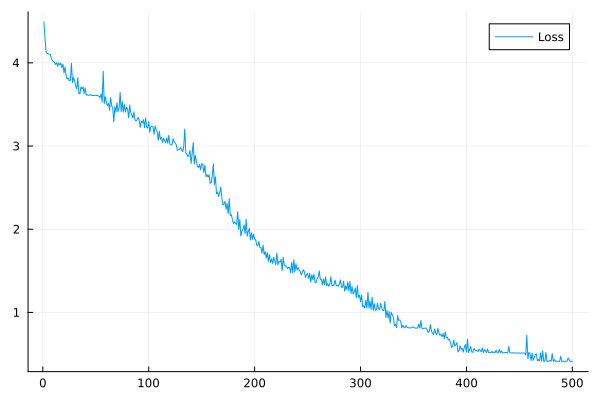

In [129]:
epoch_data() = Flux.DataLoader((encoded_x, encoded_y); batchsize=1, shuffle=true)
nepochs = 500
L = []
using Plots
l = 0
for e in 1:nepochs
    data = epoch_data()
    for dat in data
        grad = gradient(ps) do
            loss(dat...)            
        end
        push!(L, loss(dat...))
        IJulia.clear_output(true)
        Flux.update!(ADAM(0.001), ps, grad)
        display(plot(L, label="Loss"))
    end
end

In [131]:
function transcribe_protein(x)
    seq = [tokenizer_y("1")]
    tok = ["1"]
    enc = Tencoder(x)
    for i = 1:2*length(x)
        dec = Tdecoder((seq, enc))
        seqnext = argmax(vec(dec[1:end-1,end]))
        append!(seq, seqnext)
        toknext = Transformers.decode(tokenizer_y, seqnext)
        push!(tok, toknext)
        toknext == "9" && break
    end
    tok
end

function pointwise_accuracy(xtrain, ytrain)
    global_acc = 0
    @showprogress for i in 1:length(xtrain)
        xi = transcribe_protein(xtrain[i])
        yi = ytrain[i]
        

#         diff = abs(length(xi) - length(yi))
#         if length(xi) < length(yi)
#             post = ["uu" for i in 1:diff]
#             xi = cat(xi, post; dims=1)
#         elseif length(yi) < length(xi)
#             post = ["uu" for i in 1:diff]
#             yi = cat(yi, post; dims=1)
#         end
        local_acc = sum( xi .== yi ) / length(yi)
        global_acc += local_acc
    end
    return global_acc / length(xtrain)
end



pointwise_accuracy (generic function with 1 method)

In [149]:
[transcribe_protein(encoded_x[1]), pre_process(train_y[1])]

2-element Vector{Vector{String}}:
 ["1", "1", "1", "M", "M", "M", "S", "S", "H", "H"  …  "T", "T", "T", "T", "Y", "Y", "Y", "Y", "Y", "9"]
 ["1", "A", "N", "M", "K", "S", "Q", "H", "K", "A"  …  "H", "V", "K", "T", "D", "Y", "Y", "E", "Y", "9"]